In [1]:
import os
import sys
import json
import warnings
import itertools
from pathlib import Path


import torch
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import mnmstpy as mnmst
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

from falcon import FALCON
from utils import get_laplace_matrix, torch_soft,seed_setting,min_max_normalize,svd,to_tensor,Ge,priori_cluster,refine



warnings.filterwarnings("ignore")
NOISE=[None]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epoch = 5

def analysis_humanbreastcancer(noise_level):
    seed_setting(42)
    adata = sc.read_h5ad('../data/Breast_Cancer/V1/breast_cancer_v1.h5ad')
   
    adata_full = adata.copy()  
    if noise_level is not None:
        adata.X = add_gaussian_noise(adata.X, noise_level)

    # use prior information to get best clustering
    N_CLUSTER = adata.obs["Ground Truth"].nunique()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata = adata[:, adata.var['total_counts'] > 100]
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.filter_genes(adata, min_cells=1)
    hvg_filter = adata.var['highly_variable']
    sc.pp.normalize_total(adata, inplace=True)
    #adata = adata[:, hvg_filter]

    enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.6)
    sc.pp.pca(enhanced_adata, n_comps=20)
    low_dim_x = enhanced_adata.obsm['X_pca']
    expression = low_dim_x
    count_sub = np.apply_along_axis(min_max_normalize, 0, expression)
    spatial_network = cell_spatial
    w2 = spatial_network.toarray()
    w2 = (w2+w2.T)/2
    dim = 32
    n_spot = count_sub.shape[0]
    n_neighbor = 15
    init_W = cosine_similarity(count_sub)
    cos_init = np.zeros((n_spot, n_spot))
    for i in range(n_spot):
        vec = init_W[i, :]
        distance = vec.argsort()[:: -1]
        for t in range(n_neighbor + 1):
            y = distance[t]
            cos_init[i, y] = init_W[i, y]

    w1 = cos_init

    # initialization
    svd_result_x = svd(np.transpose(w1), dim)
    mat_bg = np.abs(svd_result_x[0] @ np.sqrt(svd_result_x[1]))
    mat_gG = Ge(dim)
    mat_fg = np.abs(np.sqrt(svd_result_x[1]) @ svd_result_x[2])


    svd_result_k = svd(w2, dim)
    mat_bs = np.abs(svd_result_k[0] @ np.sqrt(svd_result_k[1]))
    mat_gs = Ge(dim)
    mat_fs = np.abs(np.sqrt(svd_result_k[1]) @ svd_result_k[2])


    alpha = [10]
    beta = [1]

    parameters_grid = itertools.product(alpha, beta)
    lap_w2 = get_laplace_matrix(w2)
    parameters = {"device": "cuda" if torch.cuda.is_available() else "cpu",
                  "gene_number": w1.shape[0],
                  "feature_dimension": dim,
                  # PENALTY
                  "alpha": 0.01,
                  # LPP
                  "beta": 0.01,
                  # AFFINITY
                  "gamma": 0,
                  # CONTRASTIVE
                  "eta": 0,
                  "spot_number": w1.shape[1],
                  "epochs": Epoch,
                  'n_cluster': N_CLUSTER,
                  "bg": mat_bg.astype(np.float32),
                  "bs": mat_bs.astype(np.float32),
                  "fg": mat_fg.astype(np.float32),
                  "fs": mat_fs.astype(np.float32),
                  "a": cos_init,
                  "lap_ws": lap_w2.astype(np.float32),
                  "wg": w1,
                  "ws": w2,
                  "eg": np.random.normal(loc=np.mean(mat_fg), scale=0.1, size=mat_fg.shape) * 0.1
                  }
    parameters_torch = {k: to_tensor(v,parameters["device"]) for k, v in parameters.items()}
    config_torch = {
        'learning_rate': 1e-3,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8,
        'm': torch.zeros_like(parameters_torch['a']),
        'v': torch.zeros_like(parameters_torch['a']),
        't': 0
    }

    for p in parameters_grid:
        config_torch = {
            'learning_rate': 1e-3,
            'beta1': 0.9,
            'beta2': 0.999,
            'epsilon': 1e-8,
            'm': torch.zeros_like(parameters_torch['a']),
            'v': torch.zeros_like(parameters_torch['a']),
            't': 0
        }

        parameters["alpha"] = p[0]
        parameters["beta"] = p[1]
        parameters_torch = {k: to_tensor(v,parameters["device"]) for k, v in parameters.items()}
        fg, fs, a, eg, err,b = FALCON(parameters_torch, config_torch)
        key_added = 'representation'
        conns_key = 'representation'
        dists_key = 'representation'
        adata.uns[key_added] = {}
        representation_dict = adata.uns[key_added]

        representation_dict['connectivities_key'] = conns_key
        representation_dict['distances_key'] = dists_key
        representation_dict['var_names_use'] = adata.var_names.to_numpy()

        representation_dict['params'] = {}
        representation_dict['params']['method'] = 'umap'
        adata.obsp['representation'] = a
        res = priori_cluster(adata,n_domains=parameters_torch['n_cluster'])
        sc.tl.leiden(adata, neighbors_key='representation',random_state=0, resolution=res, key_added='FALCON',n_iterations=5,flavor="igraph",directed=False)
        weights_adj = cell_spatial.toarray()
        refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['FALCON'].tolist(), dis=weights_adj,
                              shape="hexagon")
        adata.obs["refine_FALCON"] = refined_pred
        adata.obs["refine_FALCON"] = adata.obs["refine_FALCON"].astype('category')

        adata_valid = adata[adata.obs['Ground Truth'] != 'Excluded']
        cur_ari = adjusted_rand_score(pd.Categorical(adata_valid.obs['FALCON']).codes,
                                      pd.Categorical(adata_valid.obs['Ground Truth']).codes)
        refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refine_FALCON'])
        nmi = normalized_mutual_info_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['FALCON'])
        refine_nmi = normalized_mutual_info_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refine_FALCON'])
        return adata,adata_full,refine_ari,fg,eg,b,fs,a

adata,adata_full,ari,fg,eg,b,fs,a = 0,0,0,0,0,0,0,0
for noise_level in NOISE:
    adata,adata_full,ari,fg,eg,b,fs,a  = analysis_humanbreastcancer(noise_level)


Median distance to closest cell = 273.7480593538519
num_nbrs: 14066
## Epoch 0 | err1=290.414530, err2=2.478582, err3=253.407827
## Epoch 1 | err1=286.208738, err2=0.422424, err3=231.941892
## Epoch 2 | err1=281.525605, err2=1.321673, err3=231.436522
## Epoch 3 | err1=278.732948, err2=3.237976, err3=231.489005
## Epoch 4 | err1=276.830146, err2=11.940823, err3=232.009243


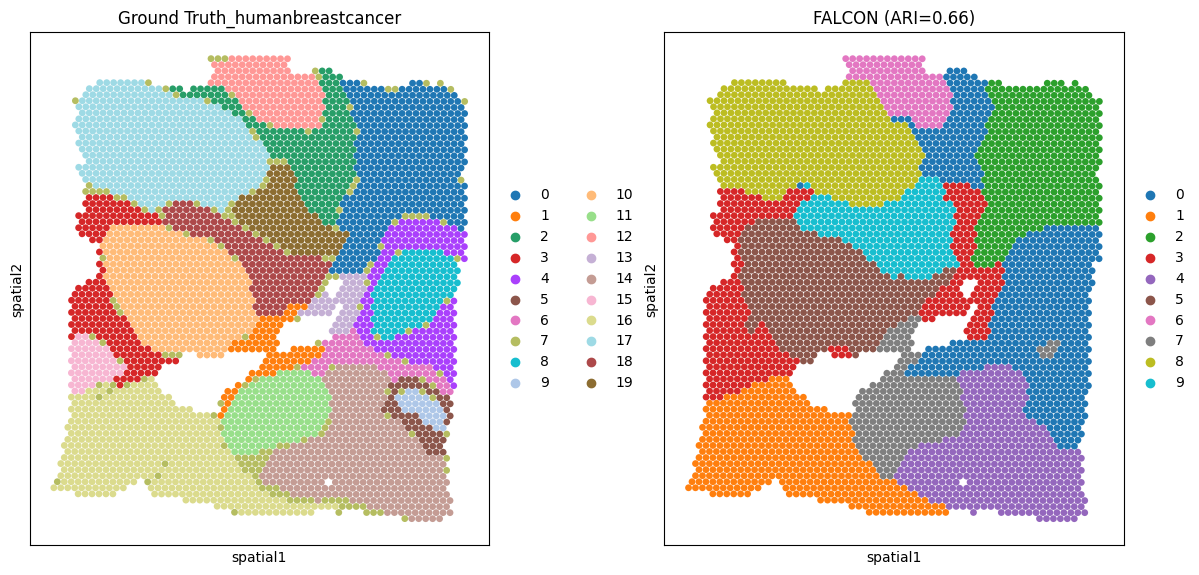

In [2]:
key_added = 'representation'
conns_key = 'representation'
dists_key = 'representation'
adata.uns[key_added] = {}
representation_dict = adata.uns[key_added]

representation_dict['connectivities_key'] = conns_key
representation_dict['distances_key'] = dists_key
representation_dict['var_names_use'] = adata.var_names.to_numpy()

representation_dict['params'] = {}
representation_dict['params']['method'] = 'umap'
adata.obsp['representation'] = a
sc.tl.leiden(adata, neighbors_key='representation',random_state=0, resolution=0.38, key_added='FALCON',n_iterations=5,flavor="igraph",directed=False)


adata_valid = adata[adata.obs['Ground Truth'] != 'Excluded']
nmi = normalized_mutual_info_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['FALCON'])
ari = adjusted_rand_score(
    pd.Categorical(adata_valid.obs['FALCON']).codes,
    pd.Categorical(adata_valid.obs['Ground Truth']).codes
)
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refine_FALCON'])
# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.spatial(
    adata[adata.obs['cell type'] != 'Excluded'],
    img_key=None,
    color='Ground Truth',
    ax=axes[0],
    title='Ground Truth_humanbreastcancer',
    size=1.5,
    show=False
)

sc.pl.spatial(
    adata[adata.obs['FALCON'] != 'Excluded'],
    img_key=None,
    color='FALCON',
    ax=axes[1],
    title='FALCON (ARI=%.2f)' % ari,
    size=1.5,
    show=False
    
)

plt.tight_layout()
plt.savefig(f"./figures/FALCON_humanbreastcancer_noise_std:{NOISE}.pdf", dpi=600, bbox_inches="tight", format="pdf")
plt.show()
